# preparing

In [34]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time
from plotly.subplots import make_subplots

## prepare paths

The number of learning iterations

In [2]:
cycle_test=25

The path to files results of AQO in learning, frozen and disabled mode.
You should correct main_path!

In [4]:
main_path='/home/alena/Test-AQO/JOB'
disabled_path="{}/disabled".format(main_path)
frozen_path='{}/frozen'.format(main_path)
learn_path='{}/learn'.format(main_path)

## prepare func import dataframes

Foe learning dataset

In [15]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_explains_plans = pd.DataFrame()
    df_query_err=pd.DataFrame()
    df_query_stat=pd.DataFrame()
    df_query_data=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]
    
    #explains
    dict_q={}
    dict_q_text={}
    lst=[]
    q=''
    plan=''
    k=0

    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    df_ex_pl_time = df_ex_pl_time.rename(columns = {'Plan time': 'plan_time',
                                         'Query Number':'query_number', 
                                         'Query Name':'query_name', 
                                         'Execution Time':'execution_time', 
                                         'Query hash':'query_hash'})
    df_ex_pl_time['query_hash'] = df_ex_pl_time['query_hash'].astype(str)
    df_ex_pl_time['plan_time'] = df_ex_pl_time['plan_time'].astype(float)
    df_ex_pl_time_orig=df_ex_pl_time.copy()
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df_ex_pl_time = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df_ex_pl_time['exec_time_avg'] = df_ex_pl_time['execution_time']/times
        df_ex_pl_time['plan_time_avg'] = df_ex_pl_time['plan_time']/times
    
    if mode !='disabled':
        #err
        filename_basics=glob.glob("{}/*_err*.csv".format(path_folder, mode))
        lst=[]
        df_list=[]
        def f(lst,k,l):
            lst_temp=[k]*l
            lst = lst+lst_temp
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_query_err = pd.concat(df_list, ignore_index=True)
        else:
            df_query_err = df_list[0]
        #df_list['iteration']=lst
        #print(df_query_err.columns)
        df_query_err['id'] = df_query_err['id'].astype(str)
        df_query_err['errdelta'] = df_query_err['errdelta'].astype(float)
        
        dict_hash = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_hash in dict_hash:
                dict_hash[str(i.query_hash)].append(i.query_name)
            else:
                dict_hash[i.query_hash] = []
                dict_hash[str(i.query_hash)].append(i.query_name)
        df_temp=pd.DataFrame(dict_hash.items())
        df_temp.columns=['queryid', 'query_name']
        df_temp['queryid'] = df_temp['queryid'].astype(str)
        #print(df_query_stat.columns)
        df_query_err=df_query_err.merge(df_temp,left_on='id', right_on='queryid')
        df_query_err['query_name'] = df_query_err['query_name'].astype(str)
        df_query_err=df_query_err.drop(columns=['queryid'])
    
        return df_ex_pl_time, df_ex_pl_time_orig, df_query_err

In [17]:
learn_df_ex_pl_time, learn_df_ex_pl_time_orig, learn_df_query_err=get_df(learn_path,'learn',150)

      Query Number Query Name  Execution Time  Plan time            Query hash
0               22    10a.sql         486.755     29.036  -4409698924550295459
1               22    10b.sql         228.466     26.814   2327673058233797615
2               22    10c.sql       23136.476     26.861   8860988427713565746
3               22    11a.sql          80.226     59.528  -8745628810626288278
4               22    11b.sql          34.598     51.274  -9046130082131908017
...            ...        ...             ...        ...                   ...
2707            21     8d.sql        5960.610     29.240   7828965998619474049
2708            21     9a.sql        1005.637     72.223   9182348733289197053
2709            21     9b.sql        3793.434     73.341    759743340442407318
2710            21     9c.sql        1782.460     61.613  -3495764495604230484
2711            21     9d.sql       11443.504     61.709  -3970444003182879231

[2712 rows x 5 columns]


In [18]:
learn_df_ex_pl_time

query_name  execution_time            query_hash  plan_time  \
0      10a.sql       12401.340  -4409698924550295459    708.085   
1      10b.sql        5298.388   2327673058233797615    640.922   
2      10c.sql      552439.369   8860988427713565746    613.378   
3      11a.sql        1967.135  -8745628810626288278   1613.225   
4      11b.sql         955.627  -9046130082131908017   1339.754   
..         ...             ...                   ...        ...   
108     8d.sql      142404.497   7828965998619474049    672.217   
109     9a.sql       35445.951   9182348733289197053   1689.157   
110     9b.sql       88678.004    759743340442407318   1652.440   
111     9c.sql       42772.854  -3495764495604230484   1504.383   
112     9d.sql      326722.139  -3970444003182879231   1441.665   

     exec_time_avg  plan_time_avg  
0        82.675600       4.720567  
1        35.322587       4.272813  
2      3682.929127       4.089187  
3        13.114233      10.754833  
4         6.370847       8.931693  
..             ...            ...  
108     949.363313       4.481447  
109     236.306340      11.261047  
110     591.186693      11.016267  
111     285.152360      10.029220  
112    2178.147593       9.611100  

[113 rows x 6 columns]

In [19]:
learn_df_ex_pl_time_orig

query_number query_name  execution_time  plan_time            query_hash
0               22    10a.sql         486.755     29.036  -4409698924550295459
1               22    10b.sql         228.466     26.814   2327673058233797615
2               22    10c.sql       23136.476     26.861   8860988427713565746
3               22    11a.sql          80.226     59.528  -8745628810626288278
4               22    11b.sql          34.598     51.274  -9046130082131908017
...            ...        ...             ...        ...                   ...
2707            21     8d.sql        5960.610     29.240   7828965998619474049
2708            21     9a.sql        1005.637     72.223   9182348733289197053
2709            21     9b.sql        3793.434     73.341    759743340442407318
2710            21     9c.sql        1782.460     61.613  -3495764495604230484
2711            21     9d.sql       11443.504     61.709  -3970444003182879231

[2712 rows x 5 columns]

In [20]:
learn_df_query_err

id  errdelta   query_name
0     7430954541387508965  0.211481  ['14b.sql']
1     7430954541387508965  0.038508  ['14b.sql']
2     7430954541387508965  0.038508  ['14b.sql']
3     7430954541387508965  0.038508  ['14b.sql']
4     7430954541387508965  0.038508  ['14b.sql']
...                   ...       ...          ...
2347  5731597360962035638  0.036481   ['7a.sql']
2348  5731597360962035638  0.036481   ['7a.sql']
2349  5731597360962035638  0.036481   ['7a.sql']
2350  5731597360962035638  0.036481   ['7a.sql']
2351  5731597360962035638  0.102416   ['7a.sql']

[2352 rows x 3 columns]

For disabled - if you don't consider statistics in aqo_query_stats

In [7]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_query_err=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                #df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]
    df_ex_pl_time['Query hash'] = df_ex_pl_time['Query hash'].astype(str)
    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    
    return df_ex_pl_time

For disabled and frozen modes if you are interested to compare the results through aqo_query_stats

In [8]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_explains_plans = pd.DataFrame()
    df_query_err=pd.DataFrame()
    df_query_stat=pd.DataFrame()
    df_query_data=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    print(filename_basics)
    if mode !='disabled':
        filename_others=['{}/{}_aqo_data.csv'.format(path_folder,mode), '{}/{}_aqo_query_stat.csv'.format(path_folder,mode)] 
        dfs = [df_query_data,df_query_err, df_query_stat]
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                print(df.columns)
                df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]

    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    df_ex_pl_time = df_ex_pl_time.rename(columns = {'Plan time': 'plan_time',
                                         'Query Number':'query_number', 
                                         'Query Name':'query_name', 
                                         'Execution Time':'execution_time', 
                                         'Query hash':'query_hash'})
    df_ex_pl_time['query_hash'] = df_ex_pl_time['query_hash'].astype(str)
    df_ex_pl_time['plan_time'] = df_ex_pl_time['plan_time'].astype(float)
    df_ex_pl_time_orig=df_ex_pl_time.copy()
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df_ex_pl_time = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df_ex_pl_time['exec_time_avg'] = df_ex_pl_time['execution_time']/times
        df_ex_pl_time['plan_time_avg'] = df_ex_pl_time['plan_time']/times

    #stat
    df_query_stat=pd.read_csv('/home/alena/Test-AQO/JOB/disabled/aqo_query_stat.csv')
    lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
       'planning_time_with_aqo', 'planning_time_without_aqo',
       'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
    lst_stat_cut = [1, 1, 1, 1, 1, 1]
    df_query_stat = get_preprocess_dataframe(df_query_stat, lst_stat_columns, lst_stat_cut)

    dict_hash = {}
    for i in df_ex_pl_time.itertuples(index=False):
        if i.query_hash in dict_hash:
            dict_hash[str(i.query_hash)].append(i.query_name)
        else:
            dict_hash[i.query_hash] = []
            dict_hash[str(i.query_hash)].append(i.query_name)
    df_temp=pd.DataFrame(dict_hash.items())
    df_temp.columns=['queryid', 'query_name']
    df_temp['queryid'] = df_temp['queryid'].astype(int)
    df_query_stat['queryid'] = df_query_stat['queryid'].astype(int)
    
    df_query_stat=df_query_stat.merge(df_temp, how='left', on='queryid')
    #df_query_stat['query_name'] = df_query_stat['query_name'].astype(str)

    return df_ex_pl_time_orig, df_query_stat, df_temp

df_temp is a link between query_hash and query file name

In [9]:
df_ex_pl_time, stats, df_temp=get_df(disabled_path,'disabled',15)

['/home/alena/Test-AQO/JOB/disabled/1_report.csv', '/home/alena/Test-AQO/JOB/disabled/3_report.csv', '/home/alena/Test-AQO/JOB/disabled/4_report.csv', '/home/alena/Test-AQO/JOB/disabled/2_report.csv']
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 'Query hash'], dtype='object')
Index(['Query Name', 'Execution Time', 'Plan time', 

/home/alena/Downloads/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/Downloads/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/Downloads/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [10]:
frozen_df_ex_pl_time, stats, df_temp=get_df(frozen_path,'frozen',15)

['/home/alena/Test-AQO/JOB/frozen/frozen_13_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_5_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_7_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_3_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_9_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_2_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_6_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_1_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_11_report.csv', '/home/alena/Test-AQO/JOB/frozen/frozen_8_report.csv']
Index(['Query Number', 'Query Name', 'Execution Time', 'Plan time',
       'Query hash'],
      dtype='object')
Index(['Query Number', 'Query Name', 'Execution Time', 'Plan time',
       'Query hash'],
      dtype='object')
Index(['Query Number', 'Query Name', 'Execution Time', 'Plan time',
       'Query hash'],
      dtype='object')
Index(['Query Number', 'Query Name', 'Execution Time', 'Plan time',
       'Query hash'],
      dtype='object')

/home/alena/Downloads/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/Downloads/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['{}_split'.format('{}'.format(column_name))].loc[k] = list(map(get_elements,i.split(',')))
/home/alena/Downloads/functions.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [11]:
frozen_df_ex_pl_time

query_number query_name  execution_time  plan_time            query_hash
0               13    10a.sql         229.182     25.998  -4409698924550295459
1               13    10b.sql         111.601     22.397   2327673058233797615
2               13    10c.sql       10380.511     20.628   8860988427713565746
3               13    11a.sql          57.631     56.237  -8745628810626288278
4               13    11b.sql          22.781     52.619  -9046130082131908017
...            ...        ...             ...        ...                   ...
1125             8     8d.sql        3293.274     24.095   7828965998619474049
1126             8     9a.sql         435.157     62.814   9182348733289197053
1127             8     9b.sql        1789.325     64.463    759743340442407318
1128             8     9c.sql         773.147     55.143  -3495764495604230484
1129             8     9d.sql        7799.272     52.856  -3970444003182879231

[1130 rows x 5 columns]

In [12]:
stats

queryid                cardinality_error_without_aqo_split  \
0   7430954541387508965  [0.960947753415567, 0.960947753415567, 0.96094...   
1  -3495764495604230484  [0.9322820300116723, 0.9322820300116723, 0.932...   
2   9182348733289197053  [1.4844389888696745, 1.4844389888696745, 1.484...   
3   7799030661291734910  [0.7825147902286559, 0.7825147902286559, 0.782...   
4  -1890080522291186125  [1.2696421809895255, 1.2696421809895255, 1.269...   
..                  ...                                                ...   
93 -2478965080048270031  [3.3101018932844606, 3.3101018932844606, 3.310...   
94  9049250486687881135  [1.6705888453978035, 1.6144752079865528, 1.614...   
95  5267282279652319986  [1.774220547782781, 1.774220547782781, 1.77422...   
96 -8852217324911197084  [1.577406813198557, 2.7556935356687307, 1.5774...   
97  5731597360962035638  [0.8382468270246983, 0.8382468270246983, 0.838...   

                     cardinality_error_with_aqo_split  \
0   [0.03850817669777474, 0.03850817669777474, 0.0...   
1   [0.03850817669777474, 0.03850817669777474, 0.0...   
2   [0.03850817669777474, 0.03850817669777474, 0.0...   
3   [0.07701635339554948, 0.07701635339554948, 0.0...   
4   [0.04332169878499658, 0.04332169878499658, 0.0...   
..                                                ...   
93  [0.03850817669777474, 0.03850817669777474, 0.0...   
94  [0.03850817669777474, 0.03850817669777474, 0.0...   
95  [0.03150669002545206, 0.03150669002545206, 0.0...   
96  [0.0471663217674666, 0.025163679035135528, 0.0...   
97  [0.03648143055578659, 0.03648143055578659, 0.0...   

                      planning_time_without_aqo_split  \
0   [0.020790356, 0.021514073, 0.019026199, 0.0192...   
1   [0.023877627, 0.023690638, 0.025620636, 0.0233...   
2   [0.022718156, 0.023816227, 0.02574899, 0.02275...   
3   [0.006967715, 0.006494765, 0.006403588, 0.0061...   
4   [0.013873057, 0.014644349, 0.012783025, 0.0133...   
..                                                ...   
93  [0.023789195, 0.023776354, 0.023785155, 0.0270...   
94  [0.02729852, 0.024535397, 0.021188935, 0.02066...   
95  [0.087954625, 0.088663218, 0.089188706, 0.0809...   
96  [0.115287146, 0.139102979, 0.128306309, 0.1219...   
97  [0.029276017, 0.029223062, 0.027332062, 0.0244...   

                         planning_time_with_aqo_split  \
0   [0.048900852, 0.048985714, 0.053167861, 0.0493...   
1   [0.059669438, 0.061208187, 0.057022197, 0.0545...   
2   [0.062068792, 0.065073608, 0.061476448, 0.0620...   
3   [0.013138738, 0.012294494, 0.013083255, 0.0118...   
4   [0.033231431, 0.035534106, 0.035461512, 0.0315...   
..                                                ...   
93  [0.042345568, 0.046907996, 0.042543329, 0.0419...   
94  [0.052811605, 0.050912566, 0.053940207, 0.0550...   
95  [0.201808492, 0.208510094, 0.205729437, 0.1878...   
96  [0.304996509, 0.308615906, 0.324235086, 0.3159...   
97  [0.058977905, 0.061429439, 0.064034958, 0.0551...   

                     execution_time_without_aqo_split  \
0   [0.237385655, 0.242997873, 0.230060608, 0.2358...   
1   [0.983308019, 0.961930579, 0.838651462, 1.4159...   
2   [4.862216727, 4.606458791, 4.675735312, 4.0634...   
3   [0.259719124, 0.233224224, 0.256330377, 0.2309...   
4   [0.273345001, 0.278808985, 0.264686493, 0.2809...   
..                                                ...   
93  [57.940145397, 51.709816846, 52.883795534, 53....   
94  [0.605218355, 0.471593952, 0.410854349, 0.2654...   
95  [25.800529768, 24.527255122, 25.619059541, 24....   
96  [0.33578476, 0.814407128, 0.361865378, 0.63082...   
97  [1.008504151, 0.903769408, 0.683380699, 0.8942...   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.221163375, 0.21725739, 0.235732091, 0.22194...                   49   
1   [1.575004969, 1.686475542, 1.497201844, 1.5749...                   49   
2   [0.802211523, 0.846898517, 0.805651845, 0.8270...                   49   
3   [0.462763122, 0.4468441

In [13]:
df_temp

queryid        query_name
0  -4409698924550295459         [10a.sql]
1   2327673058233797615         [10b.sql]
2   8860988427713565746         [10c.sql]
3  -8745628810626288278         [11a.sql]
4  -9046130082131908017         [11b.sql]
..                  ...               ...
93  7828965998619474049  [8c.sql, 8d.sql]
94  9182348733289197053          [9a.sql]
95   759743340442407318          [9b.sql]
96 -3495764495604230484          [9c.sql]
97 -3970444003182879231          [9d.sql]

[98 rows x 2 columns]

Rename columns for convinient

In [21]:
def renames(df, mode):
    df = df.rename(columns = {'plan_time':'plan_time_{}'.format(mode), 'execution_time':'execution_time_{}'.format(mode)})
    if mode == 'control' or mode == 'disabled':
        df = df.rename(columns = {'plan_time_avg':'plan_time_avg_{}'.format(mode), 'exec_time_avg':'exec_time_avg_{}'.format(mode)})
    return df

In [22]:
frozen_df_ex_pl_time=renames(frozen_df_ex_pl_time,'frozen')


In [23]:
disabled_df_ex_pl_time=renames(df_ex_pl_time,'disabled')

In [24]:
learn_df_ex_pl_time_orig=renames(learn_df_ex_pl_time_orig,'learn')

In [25]:
def renames(df, mode, column):
    df = df.rename(columns = {column:'{}_{}'.format(column,mode)})
    return df

In [26]:
learn_df_query_err=renames(learn_df_query_err,'learn','errdelta')

Let know some stastical information

In [30]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   queryid                              98 non-null     int64 
 1   cardinality_error_without_aqo_split  98 non-null     object
 2   cardinality_error_with_aqo_split     98 non-null     object
 3   planning_time_without_aqo_split      98 non-null     object
 4   planning_time_with_aqo_split         98 non-null     object
 5   execution_time_without_aqo_split     98 non-null     object
 6   execution_time_with_aqo_split        98 non-null     object
 7   executions_with_aqo                  98 non-null     int64 
 8   executions_without_aqo               98 non-null     int64 
 9   query_name                           98 non-null     object
dtypes: int64(3), object(7)
memory usage: 8.4+ KB


To store diagram

In [31]:
def upload_pics(contain, dir_to, filename):
    plotly.offline.plot(contain, image_filename=filename, image='svg')
    time.sleep(10)
    #os.replace('{}/{}.svg'.format('/home/alena/Downloads', filename), '{}/{}.svg'.format(dir_to, filename))

Form the list of query names

In [32]:
name_query = list(learn_df_query_err['query_name'].unique())

The full number of diagrams (rows + cols below)

In [36]:
ox=list(x for x in range(22))

In [37]:
fig = make_subplots(rows=11, cols=11, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_err[learn_df_query_err['query_name']==name_query[it]]
    df_temp2=stats[stats['query_name']==name_query[it]]['cardinality_error_without_aqo_split'].to_list()
    if len(df_temp2)==0:
        fig.add_trace(go.Scatter(name='cardinality_error', x = ox, 
                         y = [2]*22, line = dict(color= 'black', dash='dash')), 
              row=(it//11)+1, col=(it%11)+1)
    else:
        fig.add_trace(go.Scatter(name='cardinality_error', x = ox, 
                         y = [df_temp2[0][0]]*22, line = dict(color= 'black', dash='dash')), 
              row=(it//11)+1, col=(it%11)+1)
    fig.add_trace(go.Scatter(name='cardinality_error', x = ox, 
                         y = df_temp['errdelta_learn'].to_list()[:22], line = dict(color= 'red', dash='dot')), 
              row=(it//11)+1, col=(it%11)+1)
    fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                   title_text="Error of cardinality")
    fig.update_xaxes(title_text="Iterations", row=(it//11)+1, col=(it%11)+1)
    fig.update_yaxes(title_text="Cardinality Error", row=(it//11)+1, col=(it%11)+1)
fig.update_layout(width=4000, height = 4200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Difference cardinality')
os.rename('temp-plot.html', '{}_learn_Difference cardinality.html'.format(cycle_test))
fig.show()

find_ffmpeg failed, using the integrated library.
Opening in existing browser session.


In [40]:
stats['query_name']

0              [14b.sql]
1               [9c.sql]
2               [9a.sql]
3               [5b.sql]
4              [18b.sql]
             ...        
93             [16b.sql]
94             [12a.sql]
95             [19d.sql]
96    [22a.sql, 22b.sql]
97              [7a.sql]
Name: query_name, Length: 98, dtype: object

Compare max execution time with and without AQO

In [43]:
stats['query_name'] = stats['query_name'].astype(str)
name_query2 = list(stats['query_name'].unique())
lst_execution_time_without_aqo = []
lst_execution_time_with_aqo = []

for i in name_query2:
    df_temp=stats[stats['query_name']==i]
    lst_execution_time_without_aqo.append(max(df_temp['execution_time_without_aqo_split'].to_list()[0][-10:]))
    lst_execution_time_with_aqo.append(max(df_temp['execution_time_with_aqo_split'].to_list()[0][-10:]))

In [44]:
stackData = {
    "last execution time with aqo":lst_execution_time_with_aqo,
    "last execution time without aqo": lst_execution_time_without_aqo,
    # Use differece
    "labels": name_query2
}


fig3 = go.Figure(
    data=[
        go.Bar(
            name="frozen execution time",
            x=stackData["labels"],
            y=stackData["last execution time with aqo"],
            offsetgroup=0,
            marker_color = '#800080'
        ),
        go.Bar(
            name="disabled execution time",
            x=stackData["labels"],
            y=stackData["last execution time without aqo"],
            offsetgroup=1,
            marker_color = '#ff4d00'
        )
    ],
    layout=go.Layout(
        title="Execution time with and without AQO",
        yaxis_title="Execution time",
        xaxis_title="queries",
        width=1400, height = 800, font=dict(
        family="Courier New, monospace",
        size=16,
        color="RebeccaPurple"
    ),
        yaxis=dict(range=[0, 20]),
                 legend=dict(
    orientation = 'h', xanchor = "center", x = 0.5, y= 1)
    )
)
upload_pics(fig3, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Stack')
fig3.show()

find_ffmpeg failed, using the integrated library.
Opening in existing browser session.


In [45]:
y= [(b) / (m) for b,m in zip(lst_execution_time_without_aqo, lst_execution_time_with_aqo)]

In [46]:
lst_better2 = []
lst_better_more_than4=[]
lst_worse_less1 = []
no_better_no_worse=[]

for i in y:
    if i>2 and i<4:
        lst_better2.append(i)
    elif i>=4:
        lst_better_more_than4.append(i)
    elif i<1:
        lst_worse_less1.append(i)
    else:
        no_better_no_worse.append(i)

In [47]:
fig3 = go.Figure(
    data=[
        go.Scatter(name = 'Relative execution time', x = name_query2, y= [(b) / (m)-1 for b,m in zip(lst_execution_time_without_aqo, lst_execution_time_with_aqo)], line = dict(color= 'black', dash='solid')),
        go.Scatter(name = 'No better no worse (1)', x = name_query2, y= [1]*len(name_query2), line = dict(color= 'red', dash='dash')),
        go.Scatter(name = 'Better in 4 times (4)', x = name_query2, y= [4]*len(name_query2), line = dict(color= 'red', dash='dash')),
    go.Scatter(name = 'Worse (0)', x = name_query2, y= [0.01]*len(name_query2), line = dict(color = '#800080', dash='dash'))],
layout=go.Layout(
        title="The ratio between execution time without and with using AQO",
        yaxis_title="Relative execution time",
        xaxis_title="queries",
        width=1400, height = 800, font=dict(
        family="Courier New, monospace",
        size=16,
        color="Black"),
    yaxis=dict(range=[-1, 10]),legend=dict(orientation = 'h', xanchor = "center", x = 0.5, y= 1)
    ),
)
fig3.update_traces(texttemplate='%{text:.2s}', textposition='top center')
upload_pics(fig3, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Stack')
fig3.show()

find_ffmpeg failed, using the integrated library.
Opening in existing browser session.


find_ffmpeg failed, using the integrated library.
Opening in existing browser session.


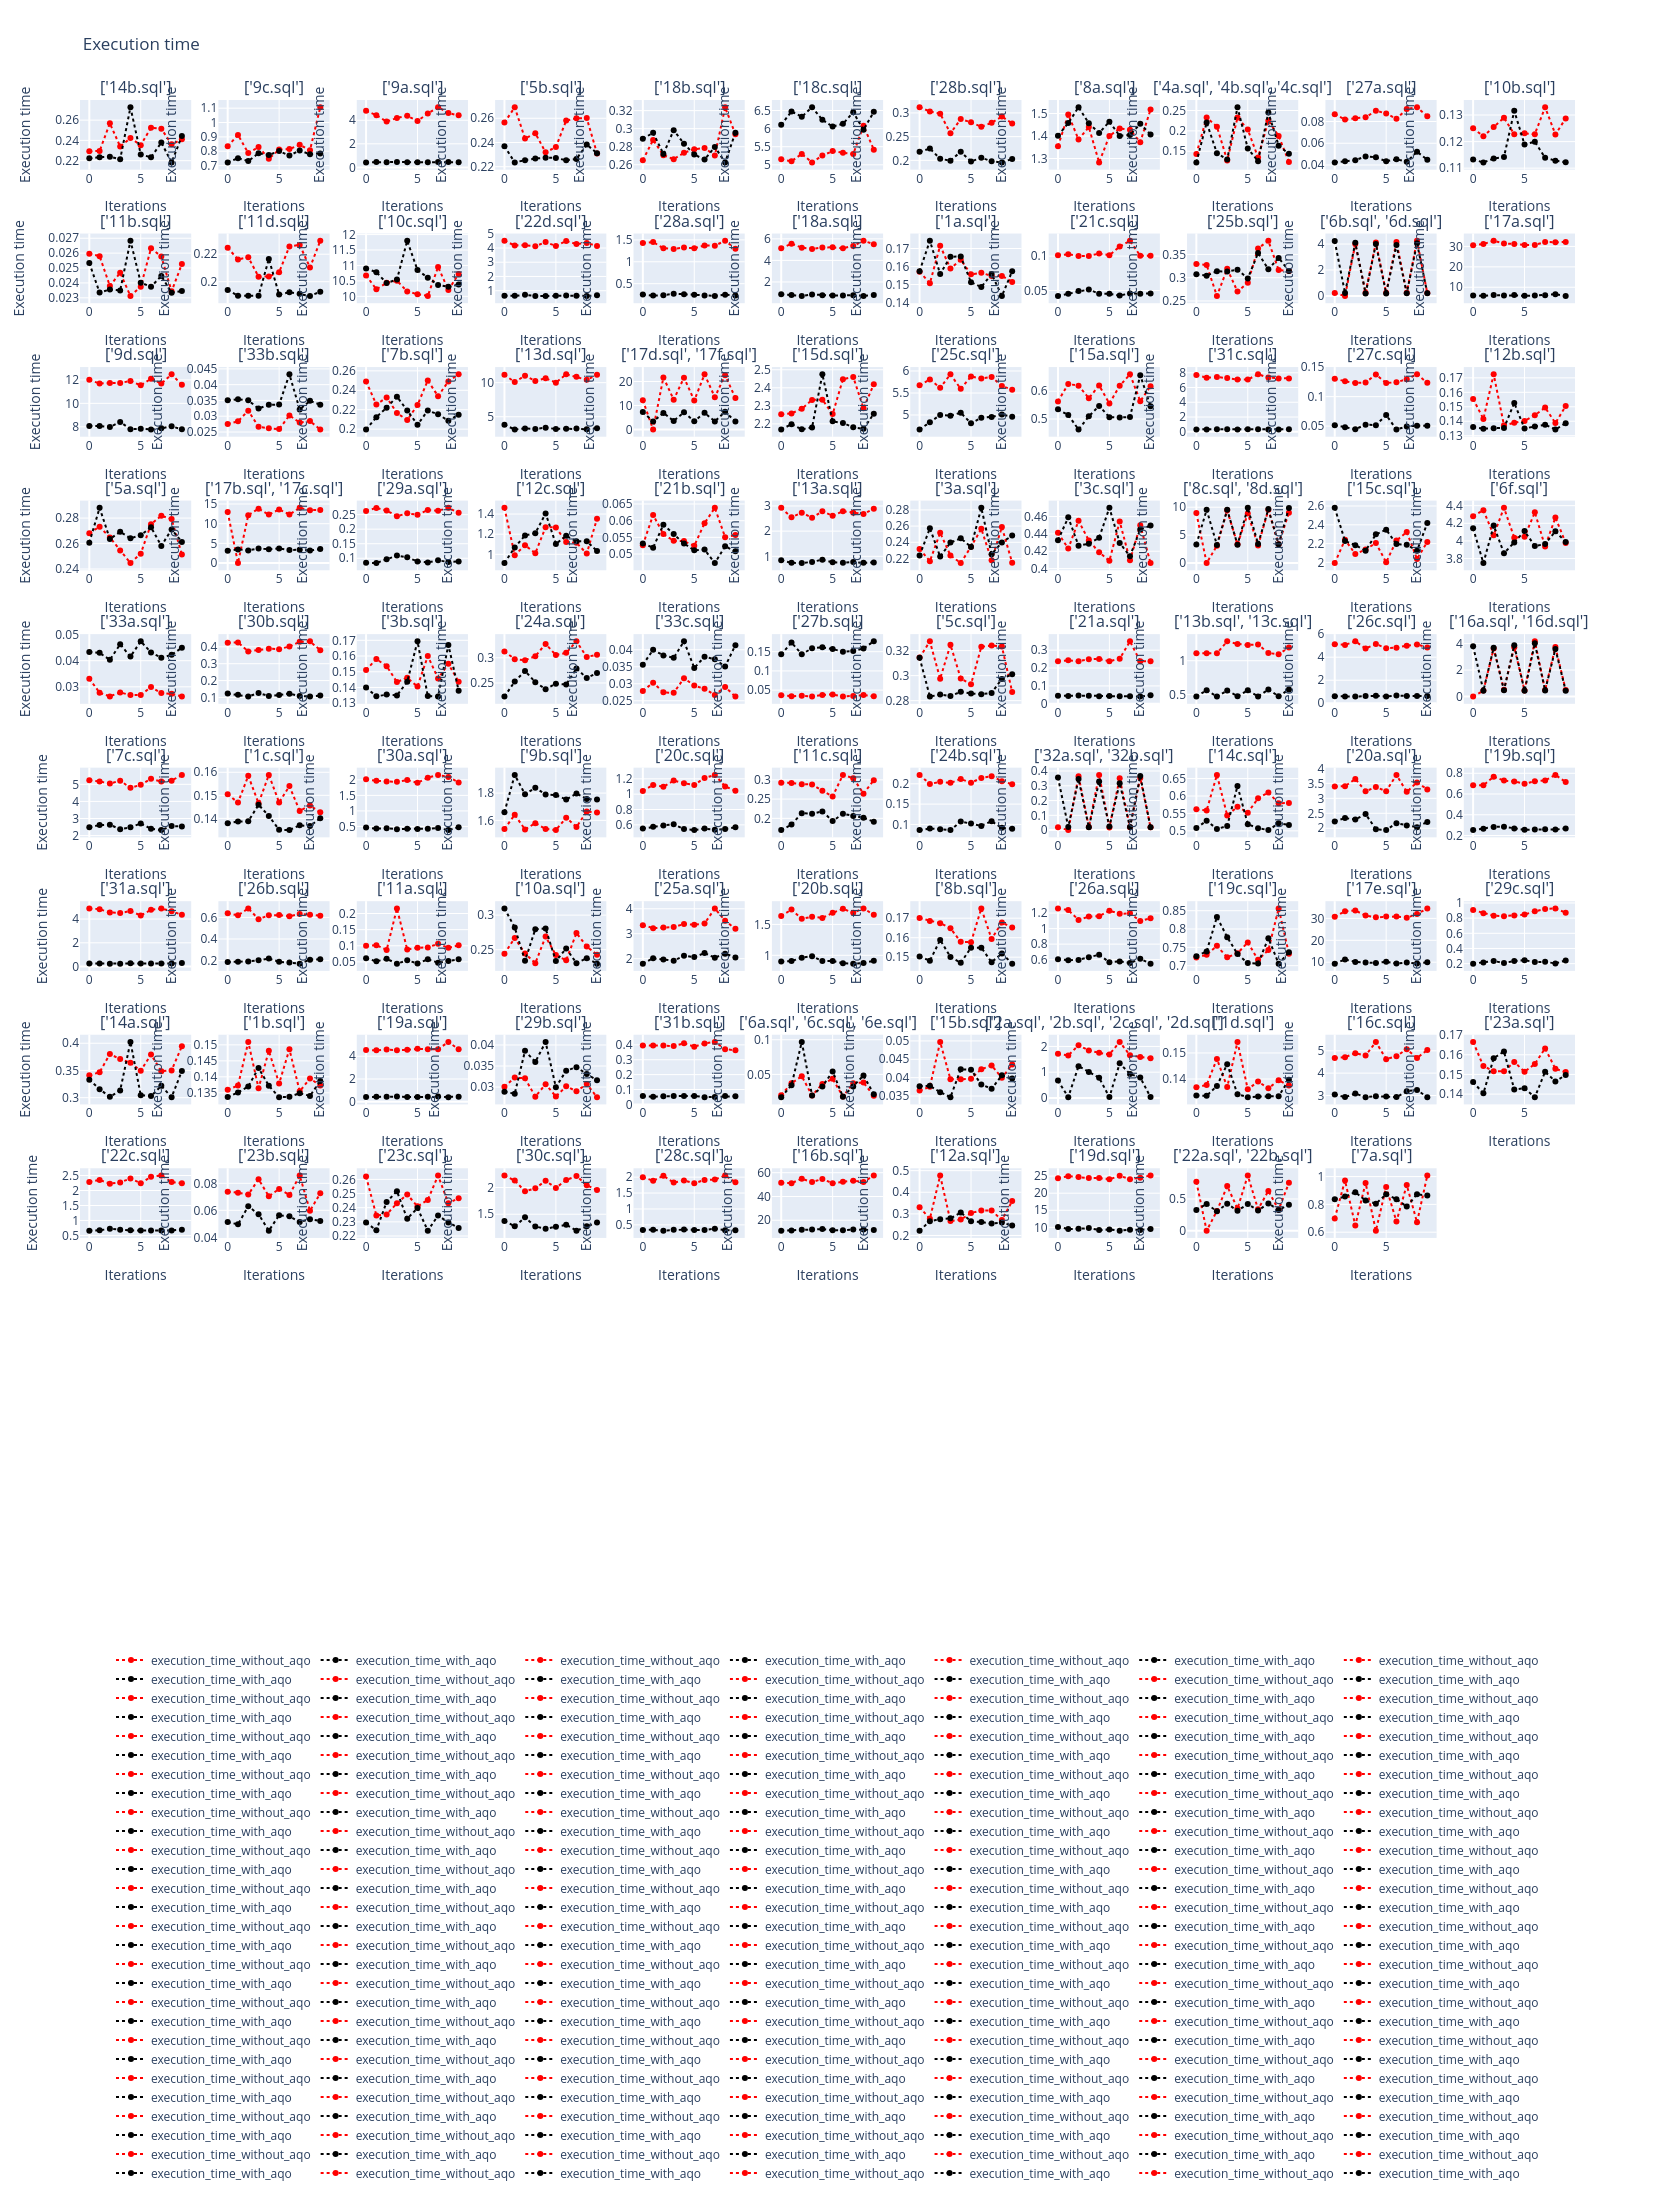

In [48]:
fig = make_subplots(rows=11, cols=11, subplot_titles=name_query)
for it, i in enumerate(name_query2):
    df_temp=stats[stats['query_name']==name_query2[it]]
    
    fig.add_trace(go.Scatter(name='execution_time_without_aqo', x = ox, 
                         y = df_temp['execution_time_without_aqo_split'].to_list()[0][-10:], line = dict(color= 'red', dash='dot')), 
              row=(it//11)+1, col=(it%11)+1)
    fig.add_trace(go.Scatter(name='execution_time_with_aqo', x = ox, 
                         y = df_temp['execution_time_with_aqo_split'].to_list()[0][-10:], line = dict(color= 'black', dash='dot')), 
              row=(it//11)+1, col=(it%11)+1)
    fig.update_xaxes(title_text="Iterations", row=(it//11)+1, col=(it%11)+1)
    fig.update_yaxes(title_text="Execution time", row=(it//11)+1, col=(it%11)+1)
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                   title_text="Execution time")
fig.update_layout(width=4000, height = 2200)
upload_pics(fig, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Difference execution time')
os.rename('temp-plot.html', '{}_learn_Exec_Time.html'.format(cycle_test))
fig.show()

In [52]:
frozen_df_query_stat = stats

In [53]:
frozen_df_query_stat['lst_min_exec_without_aqo']= min(frozen_df_query_stat['execution_time_without_aqo_split'][0])
frozen_df_query_stat['lst_min_plan_without_aqo']= min(frozen_df_query_stat['planning_time_without_aqo_split'][0])
frozen_df_query_stat['lst_min_exec_with_aqo']= min(frozen_df_query_stat['execution_time_with_aqo_split'][0])
frozen_df_query_stat['lst_min_plan_with_aqo']= min(frozen_df_query_stat['planning_time_with_aqo_split'][0])
frozen_df_query_stat['lst_min_val_with_aqo']= min(frozen_df_query_stat['cardinality_error_with_aqo_split'][0])
frozen_df_query_stat['lst_min_val_without_aqo']= min(frozen_df_query_stat['cardinality_error_without_aqo_split'][0])
#for i in frozen_df_query_stat.itertuples(index=False):

In [54]:
exec_with=[]
exec_without=[]
plan_with=[]
plan_without=[]
err_with=[]
err_without=[]
for i in frozen_df_query_stat.itertuples(index=False):
    exec_without.append(i.execution_time_without_aqo_split[0])
    plan_without.append(i.planning_time_without_aqo_split[0])
    exec_with.append(min(i.execution_time_with_aqo_split))
    plan_with.append(min(i.planning_time_with_aqo_split))
    err_without.append(i.cardinality_error_without_aqo_split[0])
    err_with.append(min(i.cardinality_error_with_aqo_split))

In [55]:
frozen_df_query_stat['lst_min_exec_without_aqo']=exec_without
frozen_df_query_stat['lst_min_exec_with_aqo']=exec_with
frozen_df_query_stat['lst_min_plan_without_aqo']=plan_without
frozen_df_query_stat['lst_min_plan_with_aqo']=plan_with
frozen_df_query_stat['lst_min_val_with_aqo']=err_with
frozen_df_query_stat['lst_min_val_without_aqo']=err_without

find_ffmpeg failed, using the integrated library.
Opening in existing browser session.


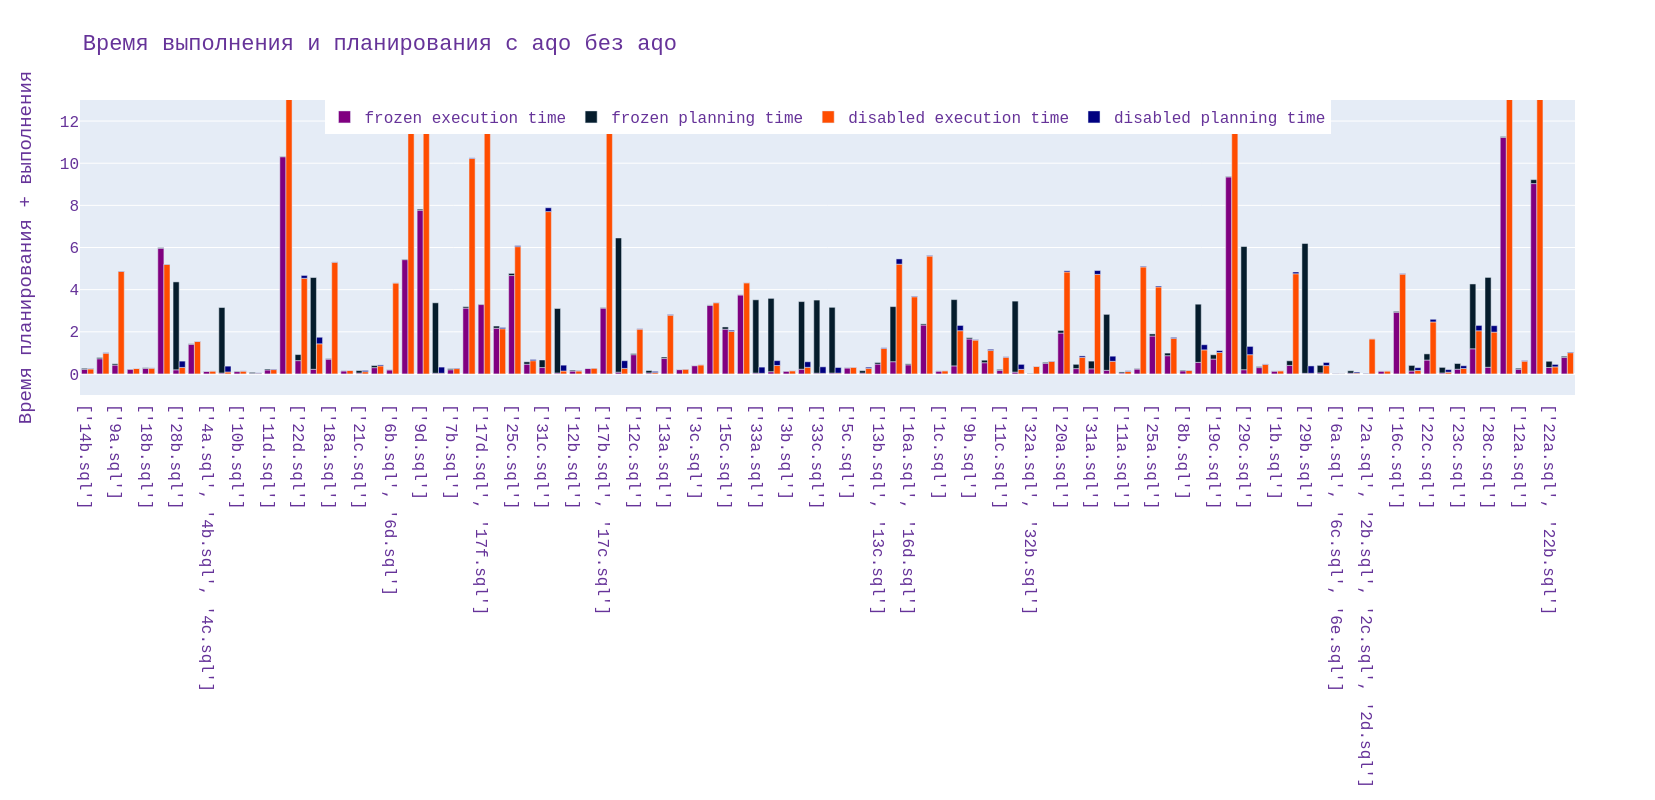

In [60]:
stackData = {
    "last execution time with aqo":frozen_df_query_stat['lst_min_exec_with_aqo'],
    "last execution time without aqo": frozen_df_query_stat['lst_min_exec_without_aqo'],
    # Use differece
    "last planning time without aqo": frozen_df_query_stat['lst_min_plan_without_aqo'],
    "last planning time with aqo":frozen_df_query_stat['lst_min_plan_with_aqo'],
    "labels": frozen_df_query_stat[frozen_df_query_stat['query_name']!='nan']['query_name']
}


fig3 = go.Figure(
    data=[
        go.Bar(
            name="frozen execution time",
            x=stackData["labels"],
            y=stackData["last execution time with aqo"],
            offsetgroup=0,
            marker_color = '#800080'
        ),
        go.Bar(
            name="frozen planning time",
            x=stackData["labels"],
            y=stackData["last planning time with aqo"],
            offsetgroup=0,
            base=stackData["last execution time with aqo"],
            marker_color = '#051c2c'
        ),
        go.Bar(
            name="disabled execution time",
            x=stackData["labels"],
            y=stackData["last execution time without aqo"],
            offsetgroup=1,
            marker_color = '#ff4d00'
        ),
        go.Bar(
            name="disabled planning time",
            x=stackData["labels"],
            y=stackData["last planning time without aqo"],
            offsetgroup=1,
            base=stackData["last execution time without aqo"],
            marker_color = '#000080'
        )
    ],
    layout=go.Layout(
        title="Время выполнения и планирования с aqo без aqo",
        yaxis_title="Время планирования + выполнения",
        width=1400, height = 800, font=dict(
        family="Courier New, monospace",
        size=16,
        color="RebeccaPurple",
    ),yaxis=dict(range=[-1, 13]),
                 legend=dict(
    orientation = 'h', xanchor = "center", x = 0.5, y= 1)
    )
)
upload_pics(fig3, '{}/{}_folder{}'.format(main_path, 'learn',cycle_test), 'Stack')
fig3.show()